In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Posterior Predictive Model Checking

### 1.1 Observed score distribution

FileNotFoundError: [Errno 2] No such file or directory: 'stan_results/teicher2015/2plq_m2_ppmc1.csv'

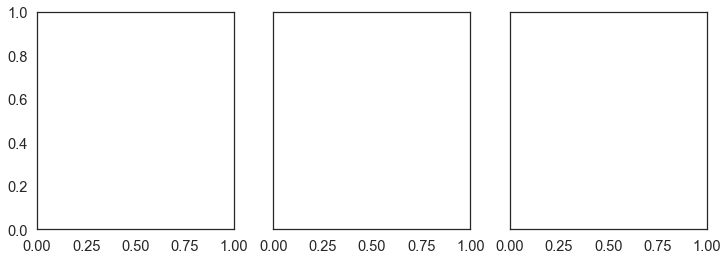

In [3]:
from arviz import hdi

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
studies = ['teicher2015','tuominen2022','joint']

for i, (ax, study) in enumerate(zip(axes, studies)):

    ## Load posterior predictive check.
    df = read_csv(os.path.join('stan_results', study, '2plq_m2_ppmc1.csv'), index_col=0)
    
    ## Normalize counts across samples.
    df.loc[:,:] /= df.loc[0].values.sum()
    
    ## Extract values.
    NC  = df.values[0]
    NCr = df.values[1:]
    ENC = NCr.mean(axis=0)
    
    ## Compute 95% HDI.
    lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)
    
    ## Compute chi-square statistics.
    xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
    xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)
    
    ## Compute ppp-value.
    pppv = (xi >= xr).mean()

    ## Plot observed scores and 95% HDI.
    ax.plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
    ax.fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)
    
    ## Add detail.
    ax.set(xticks=np.arange(0,51,10), xlabel='Observed scores', yticks=np.arange(0,0.09,0.02), 
           yticklabels=np.arange(0,9,2), ylabel='', title=study)
    if not i: ax.set_ylabel('Percent sample')
    
    ## Add annotations.
    ax.annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
sns.despine()
plt.tight_layout()

## Section 2: Factor Loadings

In [ ]:
## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

## Load Stan summary.
summary = read_csv(os.path.join('stan_results', 'joint', '2plq_m2_summary.tsv'), sep='\t', index_col=0)

## Extract factor loadings.
loadings = np.zeros((len(design), 2)).astype(float)
for i, j in np.column_stack([np.where(design)]).T:
    loadings[i,int(j > 0)] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
    
## Convert to DataFrame.
loadings = DataFrame(loadings, columns=['general','group'])
loadings.insert(0, 'item', design.index)
loadings.insert(0, 'subscale', design.columns[np.argmax(design.values[:,1:], axis=1)+1])

order = ['PVA', 'NVEA', 'PN', 'WSV', 'WIPV', 'EN', 'PPhysA', 'SexA', 'PeerVA', 'PeerPhysA']
loadings = loadings.sort_values('general', ascending=False)
loadings = loadings.set_index('subscale').loc[order].reset_index()
loadings['color'] = np.where(loadings.general > loadings.group, 'k', '#dd8452')
loadings.index = np.cumsum(np.where(loadings.subscale == np.roll(loadings.subscale, 1), 1, 2.5)) - 2.5

fig, ax = plt.subplots(1, 1, figsize=(12,4), constrained_layout=True)

for i, row in loadings.iterrows():
    ax.plot([i, i], [row.general, row.group], lw=2, color=row.color, zorder=-1)
    ax.scatter(i, row.general, s=60, color=row.color)
    
ax.set(xlim=(loadings.index.min()-1, loadings.index.max()+1), xticks=loadings.index, 
       ylim=(0.0,0.88), ylabel='Factor loadings')
ax.set_xticklabels(loadings.item, fontsize=11)
ax.grid(which='major', axis='y', color='0.4', lw=0.1, zorder=-10)

sns.despine(left=True)

#### Model 2a [Bifactor w/ 10 groups, joint data]

In [ ]:
studies = ['joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

stats = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    ## Convert to DataFrame.
    loadings = DataFrame(loadings.round(3), columns=design.columns, index=design.index)
    
    ## Re-organize DataFrame.
    cols = ['general','PVA','PPhysA','NVEA','SexA','EN','PN','WSV','WIPV','PeerVA','PeerPhysA']
    idx = np.concatenate([np.where(loadings[col])[0]+1 for col in cols[1:]])
    loadings = loadings.loc[idx, cols]
    
    ## Compute summary.
    loadings = loadings.replace({0:np.nan})
    averages = loadings.median()
    averages.name = 'summary'
    loadings = loadings.append(averages)
    
    ## Format DataFrame.
    loadings.loc[:,:] = np.where(loadings.notnull(), loadings.applymap(lambda x: '%0.3f' %x), '')

In [ ]:
print(loadings.to_latex())

## Section 3: Variance Decomposition

In [ ]:
studies = ['teicher2015', 'tuominen2022', 'joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

stats = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Coefficient omega hierachical.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Preallocate space.
    omega   = np.zeros(len(design.columns))
    omega_s = np.zeros(len(design.columns))
        
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Restrict to items in group.
        L = loadings[design[col]==1]
        
        ## Compute squared sum of factor loadings.
        A = np.square(np.sum(L, axis=0))
        
        ## Compute sum of error variances.
        B = np.sum(1 - np.square(L).sum(axis=1))
        
        ## Compute total variance.
        C = np.sum(A) + B
        
        ## Compute coefficient omega.
        omega[i] = A.sum() / C
        
        ## Compute coefficient omega subscale.
        omega_s[i] = A[i] / C
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Explained common variance.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Compute sum of squares.
    ss = np.square(loadings).sum(axis=0)
    
    ## Compute explained common variance.
    ecv = ss / ss.sum()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### H-index
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Preallocate space.
    H = np.zeros(len(design.columns))
    
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Compute squared loadings.
        s = np.square(loadings[:,i])
        
        ## Compute H-index.
        H[i] = 1. / (1 + 1 / np.sum(s / (1-s)))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Convert to DataFrame.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    stats.append(DataFrame(dict(
        subscale = design.columns,
        study = np.repeat(study, design.columns.size),
        ecv = ecv,
        omega = omega,
        omega_s = omega_s,
        H = H
    )))
    
## Concatenate DataFrames.
stats = concat(stats).replace({'teicher2015':1, 'tuominen2022': 2, 'joint': 3})

## Convert to pivot table.
stats = stats.pivot_table(['omega','omega_s','ecv','H'], 'subscale', 'study')

## Re-organize table.
index = ['general', 'PVA', 'PPhysA', 'NVEA', 'SexA', 'EN', 'PN', 'WSV', 'WIPV', 'PeerVA', 'PeerPhysA']
stats = stats.loc[index, ['omega','omega_s','ecv','H']]

In [ ]:
stats.round(3)

In [ ]:
print(stats.round(3).to_latex())